# 1. Introduction  
**Human Expression Computer Vision Project**  

**Group Name:** Finpro 1  

**Team Members:**  
- Ghozy Alfisyahr Reuski  
- Brian Nabiel Raharja  
- Muhammad Al Ghifari  
- Ali Abdurrahman  


**AbuLearn Initiative — Organization Background**

AbuLearn initiative is a nonprofit educational foundation dedicated to improving learning outcomes in digital and remore classrooms

**Background**

In online learning environments, student engagement and attentiveness are often difficult for instructors to monitor effectively compared to traditional classrooms [(Madake et al., 2022)](https://ieeexplore.ieee.org/abstract/document/10014782). The lack of direct physical interaction makes it challenging to identify whether students are actively following the lesson or becoming disengaged.



**Problem Statement**

The goal of this project is to develop a predictive machine learning model that can detect and classify students’ facial expressions during online class meetings. By recognizing emotions such as happiness, sadness, neutrality, or surprise, the system aims to provide insights into students’ attentiveness levels, thereby supporting educators in improving the quality of e-learning experiences.


**Dataset Exploration**

This section will explore objective facts and descriptive statistics.

1. What is the class distribution?
2. How many objects per image?
3. What are the resolution of the images?
4. Duplicates or Corrupted Files

**Problem Statement Exploration**

This section connects the dataset findings to the research goal.

1. Can we group the class to 3 labels?



**Objective**   

The model will classify facial expressions into the following categories:

0 → Anger

1 → Contempt

2 → Disgust

3 → Fear

4 → Happy

5 → Neutral

6 → Sad

7 → Surprise

Since these eight emotions may be too granular for the task of measuring student engagement, we also explore grouping them into three higher-level engagement states:

Very Engaged = (Happy, Surprise) 

Nominally Engaged = (Fear, Disgust, Contempt) 

Not Engaged = (Neutral, Sad, Anger)

By recognizing these emotional states, we can gain insights into how attentive students are in class and potentially improve the learning experience through adaptive teaching strategies (e.g., adding interactive content when students appear bored, or providing clarification when students look confused).


**What is this project for?** 

This project is designed to:  
- Help educators monitor student engagement during online classes.  
- Provide data-driven insights into student attentiveness.  
- Support future research in **computer vision applications for education**.  


---

# 2. Import Libraries

In [1]:
# Standard library 
import pandas as pd
import numpy as np
import random, os, hashlib, yaml, torch, shutil              # for file and directory handling

#Image processing 
import cv2                 # OpenCV, for image manipulation and analysis
from PIL import Image      # Pillow, for image loading and verification

#Data & visualization 
import seaborn as sns               # for statistical data visualization
import matplotlib.pyplot as plt     # for plotting

from pathlib import Path
from collections import Counter
from shutil import copy2
from sklearn.model_selection import StratifiedShuffleSplit

from ultralytics import YOLO

---

# 3. Data Loading

In [2]:
# Make a constant random seed
seed = 42
random.seed(seed)
np.random.seed(seed)

# Paths & settings
raw = Path("raw_data")                              # must contain raw_data/images and raw_data/labels
data_root = Path("sample_data")                     # where the sampled & split dataset will be written
sample = 7000                                       # target number of images
split = {"train": 0.8, "val": 0.1, "test": 0.1}     # must sum to 1.0

# Emotion labels (keep 8 classes for now; we’ll collapse to 3 later after EDA)
class_map = {
    0: "Anger", 1: "Contempt", 2: "Disgust", 3: "Fear",
    4: "Happy", 5: "Neutral", 6: "Sad", 7: "Surprise"}

# Quick validations (fail fast)
assert abs(sum(split.values()) - 1.0) < 1e-9, "split must sum to 1.0"
img_dir = raw / "images"
lbl_dir = raw / "labels"
assert img_dir.exists() and lbl_dir.exists(), "Expect raw_data/images and raw_data/labels to exist."

# Ensure output root exists
data_root.mkdir(parents=True, exist_ok=True)

In [3]:
# Scan & primary class per image
def list_images(img_root: Path):
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")
    files = []
    for e in exts:
        files.extend(img_root.rglob(e))
    return sorted(files)

def read_label_ids(txt_path: Path):
    ids = []
    with open(txt_path) as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            # YOLO labels: first value = class_id
            ids.append(int(float(parts[0])))
    return ids

def mode_id(ids):
    c = Counter(ids)
    m = max(c.values())
    cands = [k for k, v in c.items() if v == m]
    return min(cands)  # tie-breaker: smallest id

rows = []
for ip in list_images(img_dir):
    ip = Path(ip)
    lp = lbl_dir / f"{ip.stem}.txt"
    if not lp.exists():
        continue
    ids = read_label_ids(lp)
    if not ids:
        continue
    rows.append({
        "file_path": str(ip.resolve()),
        "label_path": str(lp.resolve()),
        "primary_class": mode_id(ids)
    })

images_df = pd.DataFrame(rows)
assert len(images_df) > 0, "No valid image/label pairs found."
print("Total pairs:", len(images_df))
print("Initial class distribution (primary_class):")
print(images_df["primary_class"].value_counts().sort_index())

Total pairs: 17101
Initial class distribution (primary_class):
primary_class
0    2339
1    1996
2    2242
3    2021
4    2154
5    1616
6    1914
7    2819
Name: count, dtype: int64


In [4]:
# Stratified subsample to 7k
target_n = int(sample)
if len(images_df) <= target_n:
    subset_df = images_df.copy()
    print(f"[INFO] total ({len(images_df)}) <= sample ({target_n}) → using all data.")
else:
    sss = StratifiedShuffleSplit(n_splits=1, train_size=target_n, random_state=seed)
    idx_train, _ = next(sss.split(images_df["file_path"], images_df["primary_class"]))
    subset_df = images_df.iloc[idx_train].reset_index(drop=True)

print("Subset size:", len(subset_df))
print("Subset class distribution:")
print(subset_df["primary_class"].value_counts().sort_index())

Subset size: 7000
Subset class distribution:
primary_class
0     957
1     817
2     918
3     827
4     882
5     662
6     783
7    1154
Name: count, dtype: int64


In [5]:
# Stratified train/val/test split ===
train_ratio = float(split.get("train", 0.8))
val_ratio   = float(split.get("val", 0.1))
test_ratio  = float(split.get("test", 0.1))

# train vs temp
sss1 = StratifiedShuffleSplit(n_splits=1, train_size=train_ratio, random_state=seed)
train_idx, temp_idx = next(sss1.split(subset_df["file_path"], subset_df["primary_class"]))
train_part = subset_df.iloc[train_idx].reset_index(drop=True)
temp_part  = subset_df.iloc[temp_idx].reset_index(drop=True)

# val vs test inside temp
rel_val = val_ratio / (val_ratio + test_ratio) if (val_ratio + test_ratio) > 0 else 0.5
sss2 = StratifiedShuffleSplit(n_splits=1, train_size=rel_val, random_state=seed)
val_idx, test_idx = next(sss2.split(temp_part["file_path"], temp_part["primary_class"]))
val_part  = temp_part.iloc[val_idx].reset_index(drop=True)
test_part = temp_part.iloc[test_idx].reset_index(drop=True)

print(f"Sizes (train:{len(train_part)}, val:{len(val_part)}, test:{len(test_part)})\n")
for name, part in [("Train",train_part), ("Val",val_part), ("Test",test_part)]:
    print(f"{name} class distribution:\n", part["primary_class"].value_counts().sort_index(), "\n")

Sizes (train:5600, val:700, test:700)

Train class distribution:
 primary_class
0    765
1    654
2    734
3    662
4    706
5    530
6    626
7    923
Name: count, dtype: int64 

Val class distribution:
 primary_class
0     96
1     81
2     92
3     83
4     88
5     66
6     78
7    116
Name: count, dtype: int64 

Test class distribution:
 primary_class
0     96
1     82
2     92
3     82
4     88
5     66
6     79
7    115
Name: count, dtype: int64 



In [6]:
# Materialize to sample_data
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

for sp in ["train","val","test"]:
    ensure_dir(data_root / "images" / sp)
    ensure_dir(data_root / "labels" / sp)

def link_or_copy(src: Path, dst: Path):
    try:
        if dst.exists():
            dst.unlink()
        os.link(src, dst)  # space/time saver
    except Exception:
        shutil.copy2(src, dst)

def ship(split_name: str, part: pd.DataFrame):
    img_out = data_root / "images" / split_name
    lbl_out = data_root / "labels" / split_name
    rows = []
    for _, r in part.iterrows():
        ip = Path(r["file_path"])
        lp = Path(r["label_path"])
        dst_img = img_out / ip.name
        dst_lbl = lbl_out / lp.name
        link_or_copy(ip, dst_img)
        link_or_copy(lp, dst_lbl)
        rows.append({
            "split": split_name,
            "image_path": str(dst_img.resolve()),
            "label_path": str(dst_lbl.resolve()),
            "primary_class": int(r["primary_class"])
        })
    return pd.DataFrame(rows)

train_df = ship("train", train_part)
val_df   = ship("val",   val_part)
test_df  = ship("test",  test_part)

print("Materialized to:", data_root.resolve())

Materialized to: /Users/alghfrimh/Folder GitHub/Final Project HCK 30 Group 1/p2-final-project-ftds-030-hck-group01-abulearn-project/sample_data


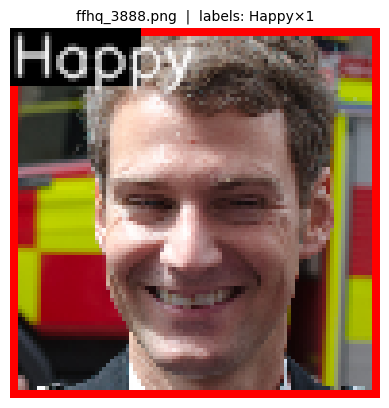

Image file : /Users/alghfrimh/Folder GitHub/Final Project HCK 30 Group 1/p2-final-project-ftds-030-hck-group01-abulearn-project/sample_data/images/train/ffhq_3888.png
Label names: ['Happy']
Counts     : {4: 1}


In [7]:
# Pick 1 random sample from train split
def show_sample_with_labels(df, seed=42, class_map=None):
    # 1) pick one row
    row = df.sample(1, random_state=seed).iloc[0]
    img_path = Path(row["image_path"])
    lbl_path = Path(row["label_path"])
    assert img_path.exists(), f"Image file not found: {img_path}"
    assert lbl_path.exists(), f"Label file not found: {lbl_path}"

    # 2) read image
    img = cv2.imread(str(img_path))
    if img is None:
        raise ValueError(f"cv2.imread returned None for: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # 3) draw boxes + collect class ids
    class_ids = []
    with open(lbl_path) as f:
        for ln in f:
            ln = ln.strip()
            if not ln: 
                continue
            parts = ln.split()
            if len(parts) < 5: 
                continue
            cls, cx, cy, bw, bh = map(float, parts[:5])   # YOLO normalized
            class_ids.append(int(cls))

            x1 = int((cx - bw/2) * w); y1 = int((cy - bh/2) * h)
            x2 = int((cx + bw/2) * w); y2 = int((cy + bh/2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

            # label text (use names if provided)
            name = class_map.get(int(cls), f"id_{int(cls)}") if class_map else str(int(cls))
            tx, ty = x1, max(12, y1 - 6)  # keep text on-canvas
            cv2.rectangle(img, (tx-2, ty-12), (tx-2 + 7*len(name), ty+2), (0,0,0), -1)  # backdrop
            cv2.putText(img, name, (tx, ty), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

    # 4) build label summary
    counts = Counter(class_ids)
    if class_map:
        label_summary = ", ".join([f"{class_map[i]}×{c}" for i, c in counts.items()])
        label_list = [class_map[i] for i in class_ids]
    else:
        label_summary = ", ".join([f"{i}×{c}" for i, c in counts.items()])
        label_list = class_ids

    # 5) show
    plt.imshow(img); plt.axis("off")
    plt.title(f"{img_path.name}  |  labels: {label_summary}", fontsize=10)
    plt.show()

    # also print clean info
    print("Image file :", img_path)
    print("Label names:", label_list)
    print("Counts     :", dict(counts))

# run it
show_sample_with_labels(train_df, seed=seed, class_map=class_map)

# 4. Exploratory Data Analysis


In [8]:
# Build split dataframes with EDA-friendly column names (no new functions)

# train
train_df = train_part.copy()
train_df["split"] = "train"
train_df["image_path"] = train_df["file_path"].astype(str)
train_df["label_path"] = train_df["label_path"].astype(str)
train_df["image_path_abs"] = train_df["image_path"].apply(lambda x: str(Path(x).resolve()))
train_df["label_path_abs"] = train_df["label_path"].apply(lambda x: str(Path(x).resolve()))

# val
val_df = val_part.copy()
val_df["split"] = "val"
val_df["image_path"] = val_df["file_path"].astype(str)
val_df["label_path"] = val_df["label_path"].astype(str)
val_df["image_path_abs"] = val_df["image_path"].apply(lambda x: str(Path(x).resolve()))
val_df["label_path_abs"] = val_df["label_path"].apply(lambda x: str(Path(x).resolve()))

# test
test_df = test_part.copy()
test_df["split"] = "test"
test_df["image_path"] = test_df["file_path"].astype(str)
test_df["label_path"] = test_df["label_path"].astype(str)
test_df["image_path_abs"] = test_df["image_path"].apply(lambda x: str(Path(x).resolve()))
test_df["label_path_abs"] = test_df["label_path"].apply(lambda x: str(Path(x).resolve()))

# combine
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# save index (optional)
index_csv = data_root / "subset_index.csv"
df.to_csv(index_csv, index=False)
print(f"Saved index: {index_csv.resolve()}")
df.head()


Saved index: /Users/alghfrimh/Folder GitHub/Final Project HCK 30 Group 1/p2-final-project-ftds-030-hck-group01-abulearn-project/sample_data/subset_index.csv


,file_path,label_path,primary_class,split,image_path,image_path_abs,label_path_abs
0,/Users/alghfrimh/Folder GitHub/Final Project H...,/Users/alghfrimh/Folder GitHub/Final Project H...,2,train,/Users/alghfrimh/Folder GitHub/Final Project H...,/Users/alghfrimh/Folder GitHub/Final Project H...,/Users/alghfrimh/Folder GitHub/Final Project H...
1,/Users/alghfrimh/Folder GitHub/Final Project H...,/Users/alghfrimh/Folder GitHub/Final Project H...,4,train,/Users/alghfrimh/Folder GitHub/Final Project H...,/Users/alghfrimh/Folder GitHub/Final Project H...,/Users/alghfrimh/Folder GitHub/Final Project H...
2,/Users/alghfrimh/Folder GitHub/Final Project H...,/Users/alghfrimh/Folder GitHub/Final Project H...,6,train,/Users/alghfrimh/Folder GitHub/Final Project H...,/Users/alghfrimh/Folder GitHub/Final Project H...,/Users/alghfrimh/Folder GitHub/Final Project H...
3,/Users/alghfrimh/Folder GitHub/Final Project H...,/Users/alghfrimh/Folder GitHub/Final Project H...,4,train,/Users/alghfrimh/Folder GitHub/Final Project H...,/Users/alghfrimh/Folder GitHub/Final Project H...,/Users/alghfrimh/Folder GitHub/Final Project H...
4,/Users/alghfrimh/Folder GitHub/Final Project H...,/Users/alghfrimh/Folder GitHub/Final Project H...,7,train,/Users/alghfrimh/Folder GitHub/Final Project H...,/Users/alghfrimh/Folder GitHub/Final Project H...,/Users/alghfrimh/Folder GitHub/Final Project H...


In [9]:
# Guards: expected columns for EDA
required_cols = {"split", "image_path", "label_path", "primary_class"}
missing = required_cols - set(df.columns)
assert not missing, f"df is missing columns: {missing}"

# Class names (8-class for now; collapse to 3 later)
id_order = sorted(class_map.keys())
class_names = [class_map[i] for i in id_order]
id2name = class_map
name2id = {v: k for k, v in class_map.items()}

len(df), df.head(2)

(7000,
                                            file_path  \
 0  /Users/alghfrimh/Folder GitHub/Final Project H...   
 1  /Users/alghfrimh/Folder GitHub/Final Project H...   
 
                                           label_path  primary_class  split  \
 0  /Users/alghfrimh/Folder GitHub/Final Project H...              2  train   
 1  /Users/alghfrimh/Folder GitHub/Final Project H...              4  train   
 
                                           image_path  \
 0  /Users/alghfrimh/Folder GitHub/Final Project H...   
 1  /Users/alghfrimh/Folder GitHub/Final Project H...   
 
                                       image_path_abs  \
 0  /Users/alghfrimh/Folder GitHub/Final Project H...   
 1  /Users/alghfrimh/Folder GitHub/Final Project H...   
 
                                       label_path_abs  
 0  /Users/alghfrimh/Folder GitHub/Final Project H...  
 1  /Users/alghfrimh/Folder GitHub/Final Project H...  )

## 4.1 - Dataset Exploration

This section will explore objective facts and descriptive statistics.

1. What is the class distribution?
2. How many objects per image?
3. What are the resolution of the images?
4. Duplicates or Corrupted Files

### 4.1.1 - What is the class distribution?

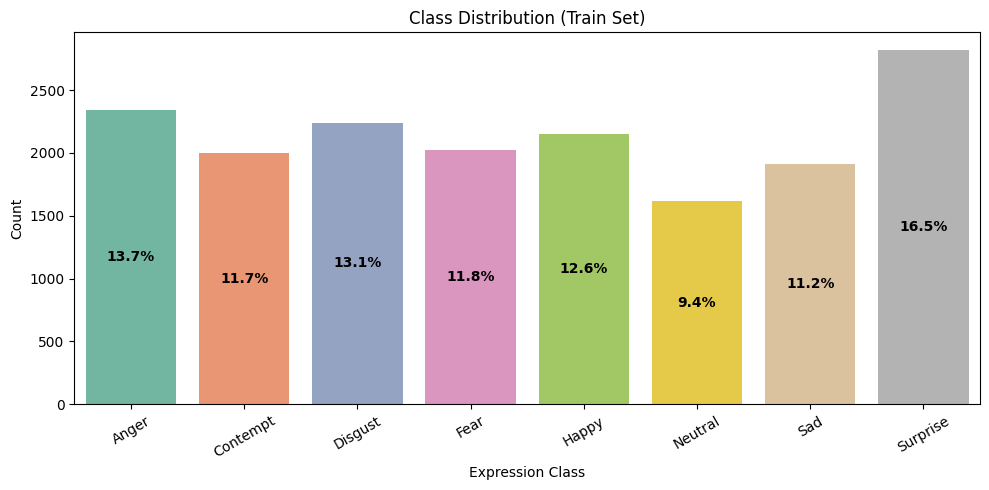

Counts by class:
 class_name
Anger       2339
Contempt    1996
Disgust     2242
Fear        2021
Happy       2154
Neutral     1616
Sad         1914
Surprise    2819
Name: count, dtype: int64

Percentages by class:
 class_name
Anger       13.68
Contempt    11.67
Disgust     13.11
Fear        11.82
Happy       12.60
Neutral      9.45
Sad         11.19
Surprise    16.48
Name: count, dtype: float64


In [5]:
#  Class mapping 
class_name = {
    0: "Anger",
    1: "Contempt",
    2: "Disgust",
    3: "Fear",
    4: "Happy",
    5: "Neutral",
    6: "Sad",
    7: "Surprise"}

#  Collect only train labels 
all_labels = []
label_dir = "raw_data/train/labels"

# Ensure the folder exists
assert os.path.isdir(label_dir), f"Folder not found: {label_dir}"

for file in os.listdir(label_dir):
    if not file.endswith(".txt"):                
        continue
    with open(os.path.join(label_dir, file), "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 5:                  
                continue
            try:
                cls = int(float(parts[0])) 
            except Exception:
                continue
            all_labels.append((cls, class_name.get(cls, f"unknown_{cls}")))

df = pd.DataFrame(all_labels, columns=["class", "class_name"])

#  Counts & Percentages (keep bar order consistent with class_name)
counts = df["class_name"].value_counts().reindex(list(class_name.values()), fill_value=0)
percentages = counts / counts.sum() * 100

#  Counts & Percentages  (keep bar order consistent with class_name)
counts_df = counts.reset_index()
counts_df.columns = ["class_name", "count"]

plt.figure(figsize=(10,5))
ax = sns.barplot(
    data=counts_df,
    x="class_name",
    y="count",
    hue="class_name",                 # <- use x as hue
    order=list(class_name.values()),   # keep the intended order
    palette="Set2",
    legend=False                      # <- hide redundant legend
)
plt.title("Class Distribution (Train Set)")
plt.xlabel("Expression Class")
plt.ylabel("Count")
plt.xticks(rotation=30)

# Annotate percentages inside bars (aligned with counts order)
for i, (count, pct) in enumerate(zip(counts_df["count"].values, percentages.values)):
    ax.text(i, (count/2) if count > 0 else 0, f"{pct:.1f}%",
            ha="center", va="center", color="black", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

# Raw counts and percentages
print("Counts by class:\n", counts)
print("\nPercentages by class:\n", percentages.round(2))


**Class Balance Analysis (Train Set)**

The dataset shows a **moderate imbalance** across facial expression classes:

* **Surprise** has the highest number of samples (**2,819**).
* **Neutral** has the lowest number of samples (**1,616**).
* Other classes (Anger, Disgust, Happy, Fear, Contempt, Sad) range between \~1,900–2,300 samples.

**Potential Issues**

* Models trained on imbalanced datasets may achieve high accuracy by **predicting the dominant class more often**.
* This reduces reliability, especially for underrepresented classes like *Neutral*, which are still important for detecting engagement.
* In practice, this means the model might overlook subtle disengagement cues while overemphasizing *Surprise*.


**Recommended Approach**

The best course of action is to apply **data augmentation techniques** to increase the representation of minority classes. Instead of duplicating samples, augmentation produces **new, varied training examples**.

**Examples of augmentation:**

* **Rotation** (slight tilts left/right)
* **Flipping** (horizontal/vertical)
* **Scaling & Cropping** (zoom in/out, random crops)
* **Brightness & Contrast adjustment**
* **Adding Gaussian noise or blur**

This method, known as **oversampling with augmentation**, helps to:

* Boost representation of minority classes (e.g., *Neutral*).
* Improve model generalization.
* Reduce the risk of overfitting compared to naive duplication.



With these steps, the dataset can be balanced more effectively, ensuring the model does not disproportionately favor the *Surprise* class while underperforming on *Neutral*.


In [6]:
# Dataset root
data_root = Path("raw_data")
assert data_root.exists(), f"Not found: {data_root.resolve()}"

rows = []
for sp in ("train", "valid", "test"):
    lbl_dir = data_root / sp / "labels"
    if not lbl_dir.exists():
        continue
    for txt in lbl_dir.glob("*.txt"):
        with open(txt, "r", encoding="utf-8") as f:
            for ln in f:
                parts = ln.strip().split()
                if len(parts) < 5:
                    continue
                try:
                    cid = int(float(parts[0]))   # first token is class id
                except Exception:
                    continue
                rows.append({
                    "split": sp,
                    "class": cid,
                    # 'class_name' uses your dict from the top cell: class_name = {0:"Anger",...}
                    "class_name": class_name.get(cid, f"unknown_{cid}")
                })

# keep an empty df with correct columns if no rows (avoids KeyError downstream)
df = pd.DataFrame(rows, columns=["split", "class", "class_name"])

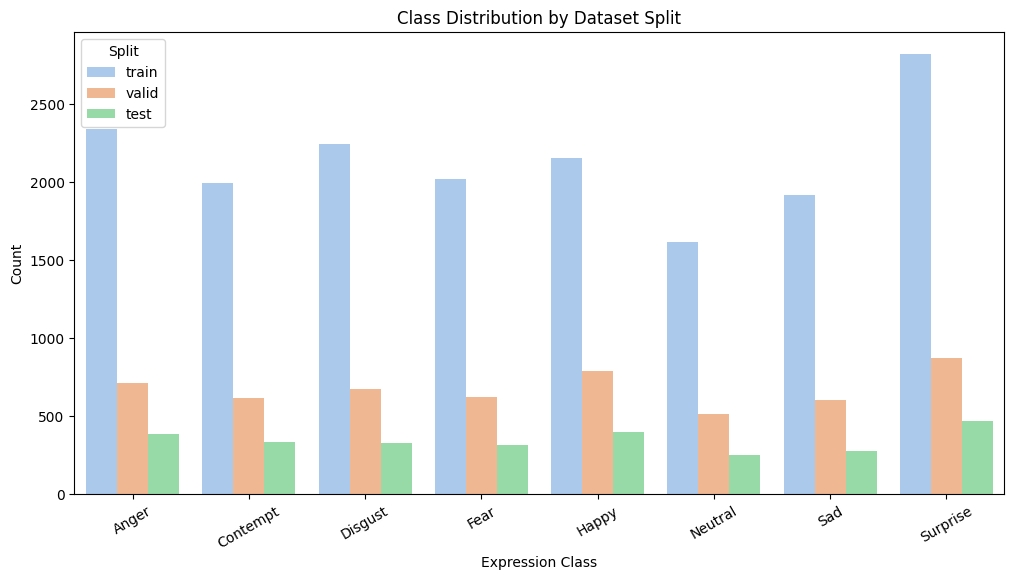

In [7]:
# 2. Class distribution by split
plot_df = df[["class", "split"]].copy()
if pd.api.types.is_numeric_dtype(plot_df["class"]):
    plot_df["class"] = plot_df["class"].map(class_name)

order = list(class_name.values())
hue_order = [s for s in ["train", "valid", "test"] if s in plot_df["split"].unique()]

plt.figure(figsize=(12, 6))
sns.countplot(
    data=plot_df,
    x="class",
    hue="split",
    order=order,
    hue_order=hue_order,
    palette="pastel"
)
plt.title("Class Distribution by Dataset Split")
plt.xlabel("Expression Class")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.legend(title="Split")
plt.tight_layout
plt.show()

The dataset splitting strategy is technically sound and well-executed. The use of a stratified split is a best practice that ensures a fair and representative evaluation of the machine learning model across all emotion categories. The relative sizes of the splits are appropriate for model development.

The primary challenge identified in the previous analysis (class imbalance) is a property of the dataset itself, not the splitting method. The splitting method has, in fact, correctly handled this imbalance by reflecting it proportionally across all splits.

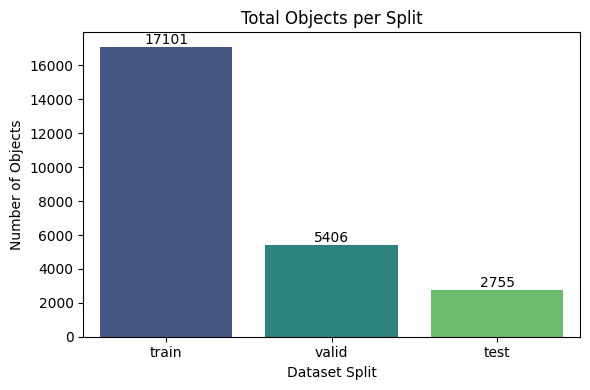

In [8]:
# --- 3. Number of objects per split ---
split_counts = (
    df.groupby("split")["class"]
      .count()
      .reset_index(name="count"))

order = [s for s in ["train", "valid", "test"] if s in split_counts["split"].tolist()]

plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=split_counts,
    x="split",
    y="count",
    order=order,
    hue="split",
    hue_order=order,
    palette="viridis",
    legend=False)

plt.title("Total Objects per Split")
plt.xlabel("Dataset Split")
plt.ylabel("Number of Objects")

# correct value labels on each bar (aligned with 'order')
for i, sp in enumerate(order):
    cnt = int(split_counts.loc[split_counts["split"] == sp, "count"].iloc[0])
    ax.text(i, cnt, f"{cnt}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

**1. Key Observations**

**A. Standard and Proportional Split Sizes:**
The distribution of data across the splits follows a very common and sensible machine learning practice, often close to a **70/15/15** or **80/10/10** ratio.
*   **Training Set (`train`):** By far the largest portion. This is optimal as the model needs a substantial amount of data to learn patterns effectively.
*   **Validation Set (`valid`):** Significantly smaller than the training set. Its size is sufficient for its purpose: evaluating the model during training to tune hyperparameters and check for overfitting.
*   **Test Set (`test`):** Roughly the same size as the validation set. This is a good size for a final, unbiased evaluation of the model's performance.

**B. Total Dataset Size:**
Estimating from the bar lengths:
*   The `train` set contains approximately **~14,000** objects.
*   The `valid` and `test` sets each contain approximately **~2,000 - 3,000** objects.
*   This puts the **total dataset size at roughly 18,000 - 20,000 objects**. This is a respectable size for a deep learning project, providing enough data to train a reasonably complex model without an extremely high risk of overfitting, provided techniques like augmentation are used.


**2. Implications**

1.  **Adequate Training Data:** The large size of the training set is a positive sign. It suggests the model has a good foundation of examples to learn from, which is crucial for achieving good performance.
2.  **Reliable Evaluation:** The validation and test sets, while smaller, are not trivial. Having a few thousand samples in each split means that the evaluation metrics (e.g., accuracy, precision, recall) calculated on them will be reasonably stable and reliable, not based on just a handful of examples.
3.  **Potential for Generalization:** This split structure is designed to build a model that generalizes well. The model is trained on one large set (`train`), its configuration is chosen based on a separate, unseen set (`valid`), and its final performance is reported on a third, completely held-out set (`test`). This helps ensure the model learns general patterns rather than memorizing the training data.



**3. Cross-Analysis with the Previous Chart**

This chart complements the previous "Class Distribution by Dataset Split" perfectly:

*   **Chart 1 (Class Distribution)** showed us the ***qualitative*** **distribution** (i.e., *how the **types** of data are split*). It confirmed the splits were stratified and revealed a significant class imbalance.
*   **Chart 2 (Total Objects per Split)** shows us the ***quantitative*** **distribution** (i.e., *how the **volume** of data is split*). It confirms the splits are of an appropriate size.

**Together, they tell a complete story:** The dataset has been split into appropriately sized subsets for training, validation, and testing, **and** the class composition of each subset is consistent and representative of the whole. This is the hallmark of a well-prepared dataset.

The main challenge remains the class imbalance identified in the first chart, but the splitting strategy itself is technically correct and robust.

### 4.1.2 - Objects per image

Average objects per image: 1.0
Max objects in an image: 1
Min objects in an image: 1


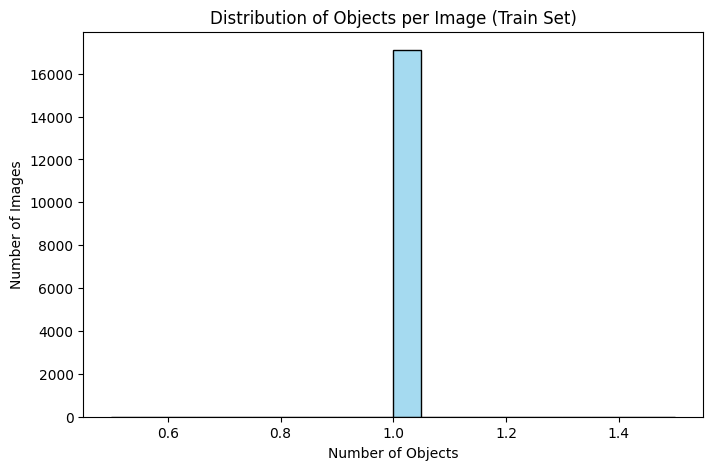

In [9]:
image_dir = "raw_data/train/images"
label_dir = "raw_data/train/labels"

objects_per_image = []

for file in os.listdir(image_dir):
    if file.endswith((".jpg", ".png", ".jpeg")):
        label_file = os.path.splitext(file)[0] + ".txt"
        label_path = os.path.join(label_dir, label_file)

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                num_objects = len(f.readlines())
        else:
            num_objects = 0  # no labels → no objects

        objects_per_image.append(num_objects)

# --- Summary statistics ---
print("Average objects per image:", sum(objects_per_image)/len(objects_per_image))
print("Max objects in an image:", max(objects_per_image))
print("Min objects in an image:", min(objects_per_image))

# --- Histogram visualization ---
plt.figure(figsize=(8,5))
sns.histplot(objects_per_image, bins=20, kde=False, color="skyblue")
plt.title("Distribution of Objects per Image (Train Set)")
plt.xlabel("Number of Objects")
plt.ylabel("Number of Images")
plt.show()

All images in the AffectNet YOLO-format dataset were found to contain exactly one object per image, as expected for a facial expression recognition task.

### 4.1.3 - What’s the resolution of the images?

Average width: 96.0
Average height: 96.0
Unique resolutions found: {(96, 96)}


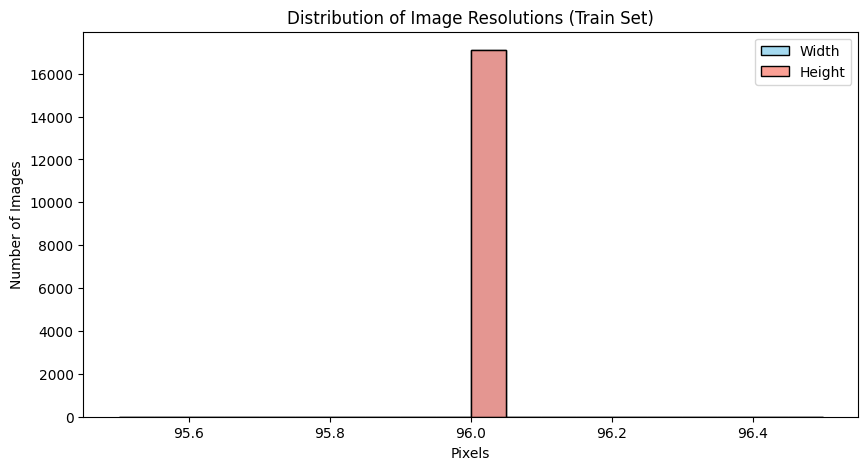

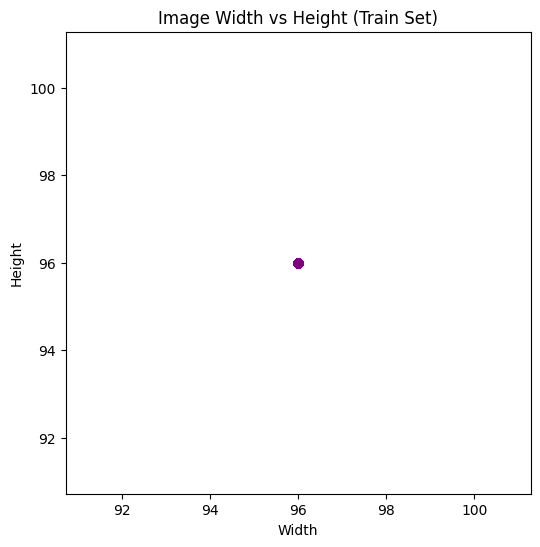

In [10]:
# --- Collect image resolutions (train set only) ---
widths, heights = [], []
image_dir = "raw_data/train/images"

for file in os.listdir(image_dir):
    img_path = os.path.join(image_dir, file)
    try:
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
    except:
        print("Corrupted image:", img_path)

# --- Summary statistics ---
print("Average width:", sum(widths)/len(widths))
print("Average height:", sum(heights)/len(heights))
print("Unique resolutions found:", set(zip(widths, heights)))

# --- Histogram visualization ---
plt.figure(figsize=(10,5))
sns.histplot(widths, bins=20, kde=False, color="skyblue", label="Width")
sns.histplot(heights, bins=20, kde=False, color="salmon", label="Height")
plt.title("Distribution of Image Resolutions (Train Set)")
plt.xlabel("Pixels")
plt.ylabel("Number of Images")
plt.legend()
plt.show()

# --- Scatterplot (width vs height) ---
plt.figure(figsize=(6,6))
plt.scatter(widths, heights, alpha=0.5, color="purple")
plt.title("Image Width vs Height (Train Set)")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

**Image Resolution Analysis (Train Set)**

* **Average width**: 96.0 px
* **Average height**: 96.0 px
* **Unique resolutions found**: {(96, 96)}

**Insights**

* All images in the training set are exactly **96×96 pixels**.
* This indicates that the dataset has already been **cleaned and standardized**.
* Since there is no variation in image size, **no additional resizing is required** during preprocessing (other than scaling pixel values).

**Implication for Modeling**

* You can directly feed images into your CNN without worrying about inconsistent dimensions.
* Data augmentation (rotation, flipping, brightness adjustment, etc.) can be applied safely, knowing that all images start with the same resolution.

### 4.1.4 - Duplicates or Corrupted files

In [11]:
image_dir = "raw_data/train/images"

# --- 1. Check corrupted files ---
corrupted_files = []
for file in os.listdir(image_dir):
    img_path = os.path.join(image_dir, file)
    try:
        with Image.open(img_path) as img:
            img.verify()  # verify file integrity
    except Exception:
        corrupted_files.append(file)

print("Number of corrupted files:", len(corrupted_files))
if corrupted_files:
    print("Corrupted files:", corrupted_files[:10])  # show first 10 if many

Number of corrupted files: 0


All images in the training set passed the integrity check, with zero corrupted files detected, indicating that the dataset has already been thoroughly cleaned and is ready for preprocessing and modeling without concerns about broken or unreadable samples.

Found 126 duplicate pairs.


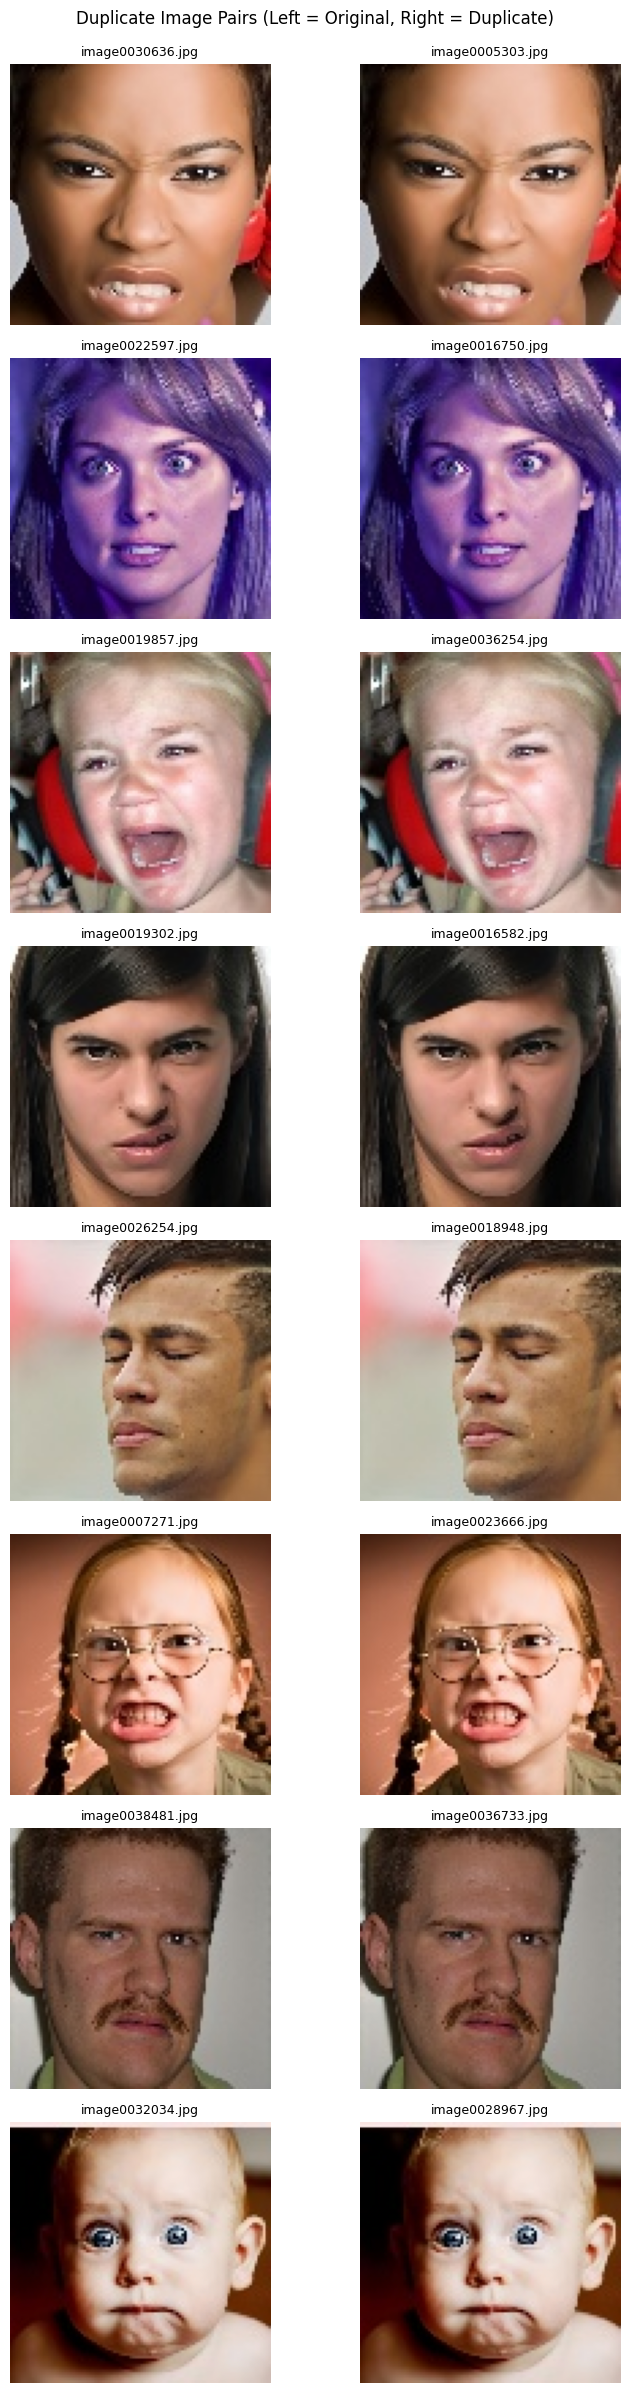

In [12]:
image_dir = "raw_data/train/images"

#  Find duplicate pairs by file hash 
hashes, duplicates = {}, []
for fname in os.listdir(image_dir):
    fpath = os.path.join(image_dir, fname)
    try:
        with open(fpath, "rb") as f:
            h = hashlib.md5(f.read()).hexdigest()
        if h in hashes:
            duplicates.append((fname, hashes[h]))  # (dup, original)
        else:
            hashes[h] = fname
    except Exception:
        continue

print(f"Found {len(duplicates)} duplicate pairs.")

#  Visualize first N duplicate pairs 
N = min(8, len(duplicates))  # change as needed
if N > 0:
    fig, axes = plt.subplots(nrows=N, ncols=2, figsize=(8, 3*N))
    if N == 1:  # handle single pair case
        axes = [axes]

    for i in range(N):
        dup, orig = duplicates[i]
        for j, fname in enumerate([orig, dup]):
            ax = axes[i][j] if N > 1 else axes[j]
            img = Image.open(os.path.join(image_dir, fname)).convert("RGB")
            ax.imshow(img)
            ax.axis("off")
            ax.set_title(fname, fontsize=9)
    plt.suptitle("Duplicate Image Pairs (Left = Original, Right = Duplicate)", y=0.995, fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("No duplicates to visualize.")

* **Duplicate pairs found:** 126
* In most computer vision datasets, especially with many unique samples, a moderate number of duplicates typically doesn’t hinder model performance. As noted by one practitioner:

  > “If it's 10,000 unique images, but then some of them occur 2 or 3 times, it won't make a noticeable difference.”
  > [Reddit](https://www.reddit.com/r/MachineLearning/comments/g7gxah/d_would_duplicate_images_in_a_dataset_noticeably/)


**Interpretation & Recommendation**

* Although there are some exact duplicates, this count is relatively low compared to the total dataset size.
* Such duplicates are usually a **non-issue**, especially when images represent the same face labeled identically.
* **However**, it’s still best practice to **remove duplicates from the validation and test sets** to avoid inflating performance metrics due to memorization.
  [Barz & Denzler (2020)](https://arxiv.org/abs/1902.00423)


## 4.2 - Problem Statement Exploration

### 4.2.1 - Can we group the class to 3 labels?


[Sharma et al. (2019)](https://arxiv.org/abs/1909.12913) proposed an engagement detection system that classifies students into three levels (**Very Engaged**, **Nominally Engaged**, and **Not Engaged at All**) using facial emotions, eye tracking, and head movement.

This supports our approach of grouping eight basic emotions into three broader categories:

**Very Engaged** = (Happy, Surprise) 

**Nominally Engaged** = (Fear, Disgust, Contempt) 

**Not Engaged** = (Neutral, Sad, Anger)

By aligning with this framework, we simplify classification, reduce imbalance, and make the results more actionable for e-learning.

Based on the literature review, we can safely group the expressions into engagement classes and visualize what the balance looks like.


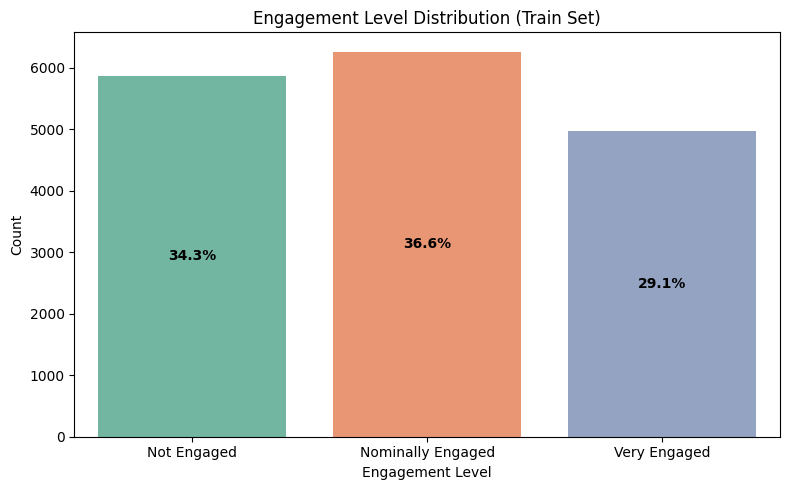

In [13]:
# Engagement mapping 
engagement_map = {
    "Happy": "Very Engaged",
    "Surprise": "Very Engaged",
    "Fear": "Nominally Engaged",
    "Disgust": "Nominally Engaged",
    "Contempt": "Nominally Engaged",
    "Neutral": "Not Engaged",
    "Sad": "Not Engaged",
    "Anger": "Not Engaged"}

# Apply mapping 
df["engagement"] = df["class_name"].map(engagement_map)

# Counting/plotting (do not leak valid/test)
if "split" in df.columns:
    _mask_train = df["split"].astype(str).str.lower().str.strip().eq("train")
    _df_plot = df.loc[_mask_train].copy()
else:
    _df_plot = df.copy()

# Fixed order for bars
eng_order = ["Not Engaged", "Nominally Engaged", "Very Engaged"]

# Counts & percentages
counts = _df_plot["engagement"].value_counts().reindex(eng_order, fill_value=0)
percentages = counts / counts.sum() * 100

# Build plotting frame (no seaborn warnings; hue is set)
counts_df = counts.reset_index()
counts_df.columns = ["engagement", "count"]

plt.figure(figsize=(8,5))
ax = sns.barplot(
    data=counts_df,
    x="engagement", y="count",
    hue="engagement",           
    order=eng_order,
    palette="Set2",
    legend=False)

plt.title("Engagement Level Distribution (Train Set)")
plt.xlabel("Engagement Level"); plt.ylabel("Count")

# Percentage labels inside bars
for i, (c, p) in enumerate(zip(counts_df["count"].values, percentages.values)):
    ax.text(i, (c/2) if c > 0 else 0, f"{p:.1f}%",
            ha="center", va="center", fontweight="bold")

plt.tight_layout()
plt.show()

**Insights**

The dataset is relatively balanced across engagement levels, but still shows some moderate imbalance.

Nominally Engaged has the largest share (36.6%), while Very Engaged is the lowest (29.1%).

Since the differences are not extreme, training a model directly on these three groups is feasible.

---

**Important Note**

Augmentation should not be done at the engagement level (3 classes), because those categories are derived, and will harm the original dataset.
Instead, augmentation must be applied to the original 8 emotion classes (Anger, Contempt, Disgust, Fear, Happy, Neutral, Sad, Surprise).

---

**Recommendation**

Apply data augmentation (rotation, flipping, brightness adjustment, etc.) to the underrepresented original emotion classes.

Then regroup into engagement levels.

This preserves a more natural balance across the three engagement categories while keeping data realistic.

---

## 4.3 - Conclusion and Recommendations Exploration

**Dataset Problems Identified in EDA**

1. **Class Distribution**

   * Moderate imbalance among the 8 classes (*Surprise* highest, *Neutral* lowest).
   * Risk of biased predictions toward majority classes.

2. **Objects per Image**

   * Exactly **1 object per image**.
   * Confirms the dataset is consistent and specialized for single-face recognition.

3. **Image Resolution**

   * All images are **96×96 pixels**.
   * Dataset is already standardized and does not require resizing.

4. **Duplicates & Corrupted Files**

   * **0 corrupted files**.
   * **126 duplicate pairs** found, but duplicates in vision datasets are generally a **minor issue** unless they appear in validation/test splits (Barz & Denzler, 2020).

---

**Key Insights from Grouping into Engagement Levels**

* Mapping 8 emotions into **3 engagement categories** (Very Engaged, Nominally Engaged, Not Engaged) makes the problem more interpretable and practical.
* Distribution across 3 groups is **relatively balanced** (36.6% Nominally Engaged, 34.3% Not Engaged, 29.1% Very Engaged).
* Augmentation should be done on the **original 8 classes**, not directly on the grouped levels, to maintain semantic validity.

---

**Recommendation for Feature Engineering (Next Step)**

1. **Data Augmentation**

   * Apply augmentation (rotation, flipping, brightness, contrast, scaling) **only to underrepresented original classes** (especially *Neutral, Sad, Contempt*).
   * This balances the dataset while preserving class semantics.

2. **Label Grouping for Engagement**

   * After augmentation, regroup emotions into **3 engagement levels**.
   * This step will reduce imbalance and simplify classification.

3. **Feature Normalization**

   * Normalize pixel values (e.g., scale 0–255 → 0–1).
   * Standardize input shape (96×96×3).

4. **Baseline Feature Extraction**

   * Start with CNN feature extraction from raw images.
   * Optionally, compare handcrafted features (e.g., histogram of oriented gradients) as a baseline.

5. **Handle Duplicates**

   * Safe to leave in training set.
   * Remove from **validation/test sets** to ensure unbiased evaluation.

---

**Final Note:**
The dataset is already **clean and standardized**, making it well-suited for CNN-based modeling. The main challenge is **class imbalance**, which should be addressed through augmentation before proceeding with model training and feature engineering.



# 5. Preprocessing

## 5.1 - Label Remapping & Dataset Setup (Emotions to Engagement Classes)

In [14]:
if "data_yaml" not in globals():
    with open("data.yaml", "r") as f:
        data_yaml = yaml.safe_load(f)

In [15]:
# Build local paths to your dataset stored under raw_data/...
raw = Path("raw_data")

def _images_dir(p_or_str) -> Path:
    """
    If p_or_str exists (e.g., a real Kaggle path), use it.
    Otherwise fallback to raw_data/<split>/images based on the path's split.
    """
    p = Path(p_or_str)
    if p.exists():
        return p
    split = p.parts[-2]  # .../<split>/images
    return raw / split / "images"

def _labels_dir_for(images_dir: Path) -> Path:
    # Swap 'images' -> 'labels' keeping same root/split
    parts = list(images_dir.parts)
    parts[-1] = "labels"
    return Path(*parts)

train_img_dir = _images_dir(data_yaml["train"])
val_img_dir   = _images_dir(data_yaml.get("val") or data_yaml.get("valid"))
test_img_dir  = _images_dir(data_yaml["test"])

SPLITS = {
    "train": {"img": train_img_dir, "lbl": _labels_dir_for(train_img_dir)},
    "valid": {"img": val_img_dir,  "lbl": _labels_dir_for(val_img_dir)},
    "test":  {"img": test_img_dir, "lbl": _labels_dir_for(test_img_dir)}}

# Quick check
for sp, d in SPLITS.items():
    print(sp, "imgs:", d["img"], "exists:", d["img"].exists(),
               "labels:", d["lbl"], "exists:", d["lbl"].exists())


train imgs: raw_data/train/images exists: True labels: raw_data/train/labels exists: True
valid imgs: raw_data/valid/images exists: True labels: raw_data/valid/labels exists: True
test imgs: raw_data/test/images exists: True labels: raw_data/test/labels exists: True


In [16]:
# Engagement names and id map (3 classes)
eng_names = ["Not Engaged", "Nominally Engaged", "Very Engaged"]
eng2id = {n: i for i, n in enumerate(eng_names)}

# Original 8-class id -> name (from YAML)
id2emo = {i: name for i, name in enumerate(data_yaml["names"])}

# 8 emotions -> 3 engagement classes
emo2eng = {
    "Happy": "Very Engaged",
    "Surprise": "Very Engaged",
    "Fear": "Nominally Engaged",
    "Disgust": "Nominally Engaged",
    "Contempt": "Nominally Engaged",
    "Neutral": "Not Engaged",
    "Sad": "Not Engaged",
    "Anger": "Not Engaged",
}

# Build 8-id -> 3-id mapping
id2eng = {emo_id: eng2id[emo2eng[id2emo[emo_id]]] for emo_id in id2emo}
id2eng, eng2id, eng_names

({0: 0, 1: 1, 2: 1, 3: 1, 4: 2, 5: 0, 6: 0, 7: 2},
 {'Not Engaged': 0, 'Nominally Engaged': 1, 'Very Engaged': 2},
 ['Not Engaged', 'Nominally Engaged', 'Very Engaged'])

In [17]:
# Target root for the 3-class dataset
out = Path("preprocess_data")
for sp in ["train", "valid", "test"]:
    (out / sp / "images").mkdir(parents=True, exist_ok=True)
    (out / sp / "labels").mkdir(parents=True, exist_ok=True)

print("Target root:", out.resolve())

Target root: /Users/alghfrimh/Folder GitHub/FINPRO 1.13.48 am/preprocess_data


In [18]:
# Convert one split: copy images and rewrite labels with new class ids (8 -> 3)
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def convert_split(split_name, src_img: Path, src_lbl: Path, out_root: Path):
    dst_img_dir = out_root / split_name / "images"
    dst_lbl_dir = out_root / split_name / "labels"
    dst_img_dir.mkdir(parents=True, exist_ok=True)
    dst_lbl_dir.mkdir(parents=True, exist_ok=True)

    n_img = n_lbl = n_empty = 0

    for img_p in sorted(src_img.iterdir()):
        if img_p.suffix.lower() not in IMG_EXTS:
            continue
        n_img += 1

        # corresponding label file
        lbl_p = src_lbl / (img_p.stem + ".txt")
        out_img = dst_img_dir / img_p.name
        out_lbl = dst_lbl_dir / (img_p.stem + ".txt")

        if not lbl_p.exists():
            # no objects — YOLO allows empty file
            out_lbl.write_text("")
            n_empty += 1
            copy2(img_p, out_img)
            continue

        lines_out = []
        with lbl_p.open("r", encoding="utf-8") as f:
            for ln in f:
                ln = ln.strip()
                if not ln:
                    continue
                parts = ln.split()
                if len(parts) < 5:
                    continue
                old_id = int(float(parts[0]))
                new_id = id2eng.get(old_id, 0)  # default to Not Engaged if unknown
                parts[0] = str(new_id)
                lines_out.append(" ".join(parts))

        out_lbl.write_text("\n".join(lines_out))
        n_lbl += 1
        copy2(img_p, out_img)

    return {"images": n_img, "with_labels": n_lbl, "empty_labels": n_empty}


In [19]:
# Run conversion for all splits using *SPLITS* (LOCAL PATHS)
for sp, d in SPLITS.items():
    print(f"[{sp}] src_img={d['img']}, src_lbl={d['lbl']}")
    assert d["img"].exists(), f"Missing images dir for {sp}: {d['img']}"
    assert d["lbl"].exists(), f"Missing labels dir for {sp}: {d['lbl']}"

summary = {}
for sp, d in SPLITS.items():    # <-- THIS is the fix
    summary[sp] = convert_split(
        split_name=sp,
        src_img=d["img"],
        src_lbl=d["lbl"],
        out_root=out)

summary

[train] src_img=raw_data/train/images, src_lbl=raw_data/train/labels
[valid] src_img=raw_data/valid/images, src_lbl=raw_data/valid/labels
[test] src_img=raw_data/test/images, src_lbl=raw_data/test/labels


{'train': {'images': 17101, 'with_labels': 17101, 'empty_labels': 0},
 'valid': {'images': 5406, 'with_labels': 5406, 'empty_labels': 0},
 'test': {'images': 2755, 'with_labels': 2755, 'empty_labels': 0}}

In [20]:
# Check a few files in the new 3-class dataset
from itertools import islice

for sp in ["train", "valid", "test"]:
    dst_img = out / sp / "images"
    dst_lbl = out / sp / "labels"
    imgs = list(islice(dst_img.glob("*.*"), 3))
    lbls = list(islice(dst_lbl.glob("*.txt"), 3))
    print(f"{sp}: imgs={len(list(dst_img.iterdir()))}, lbls={len(list(dst_lbl.iterdir()))}")
    print(" sample imgs:", [p.name for p in imgs])
    print(" sample lbls:", [p.name for p in lbls])
    if lbls:
        print(" first label:\n", lbls[0].read_text().strip(), "\n")

train: imgs=34202, lbls=17101
 sample imgs: ['ffhq_5267.png', 'ffhq_2508.png', 'image0041232.jpg']
 sample lbls: ['ffhq_4090.txt', 'image0012230.txt', 'image0042407.txt']
 first label:
 2 0.499 0.499 0.999 0.999 

valid: imgs=10812, lbls=5406
 sample imgs: ['image0038097.jpg', 'ffhq_2508.png', 'ffhq_3616.png']
 sample lbls: ['image0034591.txt', 'image0021822.txt', 'image0040210.txt']
 first label:
 1 0.499 0.499 0.999 0.999 

test: imgs=2755, lbls=2755
 sample imgs: ['image0018347.jpg', 'image0003001.jpg', 'ffhq_738.png']
 sample lbls: ['image0026195.txt', 'image0006245.txt', 'image0036386.txt']
 first label:
 1 0.499 0.499 0.999 0.999 



In [21]:
# Quick sanity check: label ids must be only {0,1,2}

root = Path("preprocess_data")
bad = []
per_split_counts = {}

for sp in ["train", "valid", "test"]:
    c = Counter()
    for p in (root/sp/"labels").glob("*.txt"):
        txt = p.read_text().strip()
        if not txt:
            continue
        for ln in txt.splitlines():
            try:
                cls = int(float(ln.split()[0]))
                c[cls] += 1
                if cls not in (0,1,2):
                    bad.append((sp, p.name, ln))
            except Exception:
                bad.append((sp, p.name, ln))
    per_split_counts[sp] = dict(c)

print("Per-split class counts:", per_split_counts)
print("Any bad lines? ->", len(bad))
if bad[:5]: 
    print("Sample bad:", bad[:5])


Per-split class counts: {'train': {2: 4973, 0: 5869, 1: 6259}, 'valid': {1: 1912, 2: 1665, 0: 1829}, 'test': {1: 977, 2: 867, 0: 911}}
Any bad lines? -> 0


## 5.3 - Save Engangement Level as YAML File

In [22]:
root = Path("preprocess_data").resolve()  # this is the target root you created earlier

cfg = {
    "path": str(root),                      # dataset root folder
    "train": "train/images",                # RELATIVE to 'path'
    "val":   "valid/images",
    "test":  "test/images",
    "nc":    3,
    "names": ["Not Engaged", "Nominally Engaged", "Very Engaged"],
}

with open("engagement.yaml", "w") as f:
    yaml.safe_dump(cfg, f, sort_keys=False)

print("Wrote engagement.yaml →", Path("engagement.yaml").resolve())
print("Dataset root:", root)

Wrote engagement.yaml → /Users/alghfrimh/Folder GitHub/FINPRO 1.13.48 am/engagement.yaml
Dataset root: /Users/alghfrimh/Folder GitHub/FINPRO 1.13.48 am/preprocess_data


In [23]:
# Purpose: validate that the folders referenced by YAML actually exist
with open("engagement.yaml") as f:
    y = yaml.safe_load(f)

root = Path(y.get("path", ".")).resolve()
splits = {k: root / Path(v) for k, v in y.items() if k in ("train", "val", "test")}

for k, p in splits.items():
    print(f"{k} images:", p)
    print("  exists:", p.exists())
    print("  count images:", len(list(p.glob("*.*"))))


train images: /Users/alghfrimh/Folder GitHub/FINPRO 1.13.48 am/preprocess_data/train/images
  exists: True
  count images: 34202
val images: /Users/alghfrimh/Folder GitHub/FINPRO 1.13.48 am/preprocess_data/valid/images
  exists: True
  count images: 10812
test images: /Users/alghfrimh/Folder GitHub/FINPRO 1.13.48 am/preprocess_data/test/images
  exists: True
  count images: 2755


# 6. Model Training

In [24]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
torch.set_num_threads(2)  # jaga CPU nggak kebanyakan thread

print("PyTorch:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())

PyTorch: 2.8.0
MPS available: True


In [25]:
for p in [Path("preprocess_data/train/labels.cache"),
          Path("preprocess_data/valid/labels.cache")]:
    if p.exists():
        print("Delete", p)
        p.unlink()

Delete preprocess_data/train/labels.cache
Delete preprocess_data/valid/labels.cache


In [26]:
model = YOLO("yolov8n.pt")

results = model.train(
    data="engagement.yaml",
    imgsz=320,
    epochs=1,
    batch=2,
    workers=0,      # ← paling penting buat hindari hang di MPS
    device="mps",
    cache=False,    # jangan cache dulu
    amp=False,      # matiin AMP dulu
    plots=False,
    verbose=True
)

print("Run dir:", results.save_dir)

Ultralytics 8.3.196 🚀 Python-3.12.11 torch-2.8.0 MPS (Apple M1)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=engagement.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=False, pose=12.0, pretrained=True, profile=Fa

KeyboardInterrupt: 